<a href="https://colab.research.google.com/github/LeoVogiatzis/medical_data_analysis/blob/main/class_imbalance_(v1_3_thyroid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To connect to local runtime and run the notebook on your computer, make sure jupyter_http_over_ws is installed and enabled (if not run command block 1 on Anaconda PowerShell) and start a Jupyter server using command block 2.

Command block 1:
```
pip install --upgrade jupyter_http_over_ws>=0.0.7
jupyter serverextension enable --py jupyter_http_over_ws
```

Command block 2:
```
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
```




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
 
dt = pd.read_csv("medical_data/Thyroid_Sick.csv")
# dt = pd.read_csv("/content/drive/MyDrive/Thyroid_Sick.csv")
# dt = pd.read_csv("Thyroid_Sick.csv")
dt.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,Class
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on thyroxine               3772 non-null   object 
 3   query on thyroxine         3772 non-null   object 
 4   on antithyroid medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid surgery            3772 non-null   object 
 8   I131 treatment             3772 non-null   object 
 9   query hypothyroid          3772 non-null   object 
 10  query hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [ ]:
dt.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


In [ ]:
dt['Class'].value_counts()

negative    3541
sick         231
Name: Class, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class', ylabel='count'>

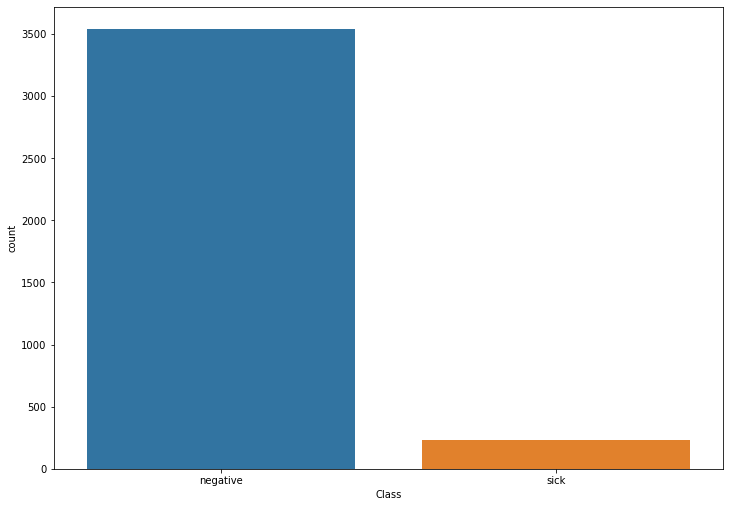

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8.5)
sns.countplot(dt['Class'])

In [ ]:
print(dt.isnull().sum())

age                             1
sex                           150
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
referral source                 0
Class         

In [ ]:
dt.drop(["TBG", "referral source"], axis=1, inplace=True)
dt = dt.loc[:, ~dt.columns.str.endswith("measured")]
dt.dropna(subset=['sex'], inplace=True)

dt = dt.replace(["f", "t"], [0, 1])
dt = dt.replace(["F", "M"], [0, 1])
dt = dt.replace(["negative", "sick"], [0, 1])

print(dt.shape)

(3622, 22)


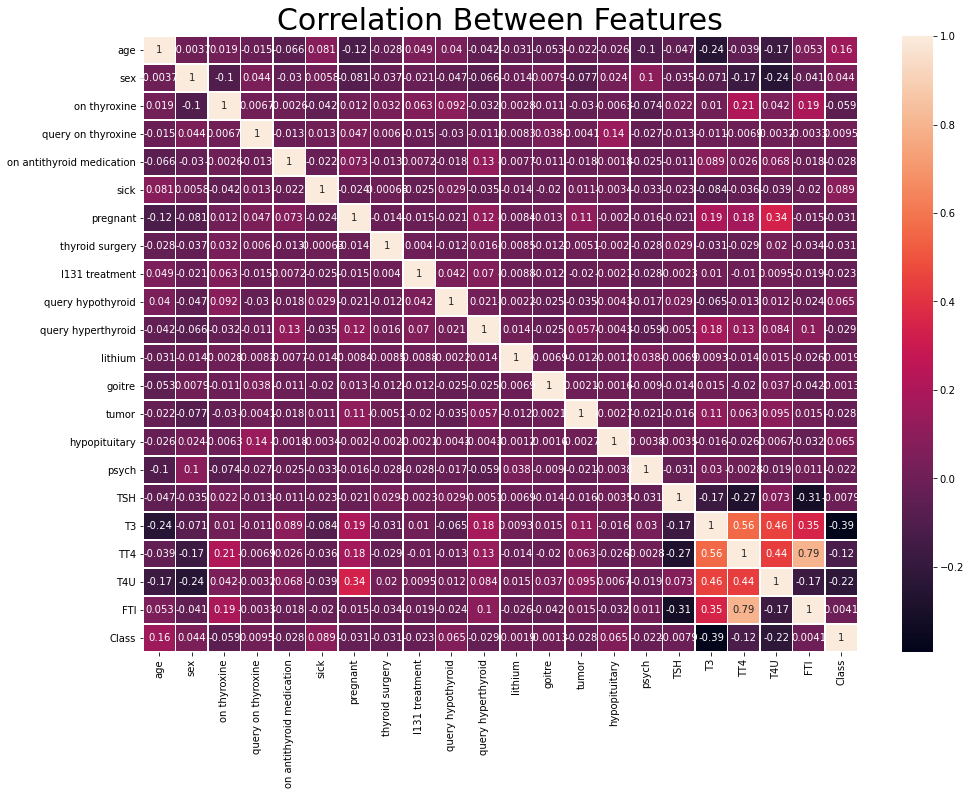

In [ ]:
plt.rcParams['figure.figsize'] = (16, 11.33) 
sns.heatmap(dt.corr(), annot = True, linewidths=.5)
plt.title('Correlation Between Features', fontsize = 30)
plt.show()

In [ ]:
X = dt.drop(columns=['Class'])
y = dt['Class']

X.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI
0,41.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.30,2.5,125.0,1.14,109.0
1,23.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.10,2.0,102.0,NaN,NaN
2,46.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.98,NaN,109.0,0.91,120.0
3,70.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0.16,1.9,175.0,NaN,NaN
4,70.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.72,1.2,61.0,0.87,70.0


In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=10)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.under_sampling import TomekLinks
from numpy import mean, empty, array
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, balanced_accuracy_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import pandas as pd

In [ ]:
def calculate_metrics (model, x_train, y_train, x_test, y_test):
  model.fit(x_train, y_train)
  probs = model.predict_proba(x_test)
  probs = probs[:, 1]

  acc_bal = balanced_accuracy_score(model.predict(x_test), y_test)
  roc_auc = roc_auc_score(y_test, probs)
  fpr, tpr, _ = roc_curve(y_test, probs)
  prec, rec, _ = precision_recall_curve(y_test, probs)
  prc_score = auc(rec, prec)

  return acc_bal, roc_auc, prc_score, fpr, tpr, rec, prec

results = pd.DataFrame(columns=["configuration", "acc_bal", "roc_auc", "prc_auc", "fpr", "tpr", "rec", "prec"])
results = results[["configuration", "acc_bal", "roc_auc", "prc_auc", "fpr", "tpr", "rec", "prec"]]


Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# row = ["Random Forest w/o SMOTE"] + list(calculate_metrics(clf, x_train, y_train, x_test, y_test))
results = results.append(dict(zip(results.columns,\
        ["Random Forest"] + list(calculate_metrics(clf, x_train, y_train,\
                                      x_test, y_test)))), ignore_index=True)

Random Forest Classifier w/ SMOTE

In [ ]:
smote = SMOTE(random_state=115, k_neighbors=10)

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)
x_s_test, y_s_test = smote.fit_resample(x_test, y_test)

clf = RandomForestClassifier(n_estimators=10, random_state=42)

results = results.append(dict(zip(results.columns,\
        ["Random Forest w/ SMOTE"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

Random Forest Classifier w/ Borderline SMOTE

In [ ]:
smote = BorderlineSMOTE(random_state=115, k_neighbors=10)

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)

clf = RandomForestClassifier(n_estimators=10, random_state=42)

results = results.append(dict(zip(results.columns,\
        ["Random Forest w/ Borderline SMOTE"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

Random Forest Classifier w/ SMOTE + Tomek Links Removal

In [ ]:
smote = SMOTE(random_state=115, k_neighbors=10)
tomek = TomekLinks()

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)
x_s_train, y_s_train = tomek.fit_resample(x_s_train, y_s_train)

clf = RandomForestClassifier(n_estimators=10, random_state=42)

results = results.append(dict(zip(results.columns,\
        ["Random Forest w/ SMOTE + Tomek Removal"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

Decision Tree Classifier

In [ ]:
clf = DecisionTreeClassifier(random_state=42)

results = results.append(dict(zip(results.columns,\
        ["Decision Tree"] + list(calculate_metrics(clf, x_train, y_train,\
                                      x_test, y_test)))), ignore_index=True)

Decision Tree Classifier w/ SMOTE

In [ ]:
smote = SMOTE(random_state=115, k_neighbors=10)

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)
x_s_test, y_s_test = smote.fit_resample(x_test, y_test)

clf = DecisionTreeClassifier(random_state=42)

results = results.append(dict(zip(results.columns,\
        ["Decision Tree w/ SMOTE"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

Decision Tree Classifier w/ Borderline SMOTE

In [ ]:
smote = BorderlineSMOTE(random_state=115, k_neighbors=10)

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)

clf = DecisionTreeClassifier(random_state=42)

results = results.append(dict(zip(results.columns,\
        ["Decision Tree w/ Borderline SMOTE"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

Decision Tree Classifier w/ SMOTE + Tomek Links Removal

In [ ]:
smote = SMOTE(random_state=115, k_neighbors=10)
tomek = TomekLinks()

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)
x_s_train, y_s_train = tomek.fit_resample(x_s_train, y_s_train)

clf = DecisionTreeClassifier(random_state=42)

results = results.append(dict(zip(results.columns,\
        ["Decision Tree w/ SMOTE + Tomek Removal"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

AdaBoost Classifier

In [ ]:
clf = AdaBoostClassifier(n_estimators=25, random_state=343)

results = results.append(dict(zip(results.columns,\
        ["AdaBoost"] + list(calculate_metrics(clf, x_train, y_train,\
                                      x_test, y_test)))), ignore_index=True)

AdaBoost Classifier w/ SMOTE

In [ ]:
smote = SMOTE(random_state=115, k_neighbors=10)

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)

clf = AdaBoostClassifier(n_estimators=25, random_state=343)

results = results.append(dict(zip(results.columns,\
        ["AdaBoost w/ SMOTE"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

AdaBoost Classifier w/ Borderline SMOTE

In [ ]:
smote = BorderlineSMOTE(random_state=115, k_neighbors=10)

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)

clf = AdaBoostClassifier(n_estimators=25, random_state=343)

results = results.append(dict(zip(results.columns,\
        ["AdaBoost w/ Borderline SMOTE"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

AdaBoost Classifier w/ SMOTE + Tomek Links Removal

In [ ]:
smote = SMOTE(random_state=115, k_neighbors=10)
tomek = TomekLinks()

x_s_train, y_s_train = smote.fit_resample(x_train, y_train)
x_s_train, y_s_train = tomek.fit_resample(x_s_train, y_s_train)

clf = AdaBoostClassifier(n_estimators=25, random_state=343)

results = results.append(dict(zip(results.columns,\
        ["AdaBoost w/ SMOTE + Tomek Removal"] + list(calculate_metrics(clf, x_s_train, y_s_train,\
                                      x_test, y_test)))), ignore_index=True)

In [ ]:
def prc_auc (clf, X, y):
  probs = clf.predict_proba(X)
  probs = probs[:, 1]
  
  prec, rec, _ = precision_recall_curve(y, probs)
  return auc(rec, prec)

Classifiers with class imbalance cost-sensitive matrix

In [ ]:
clf = RandomForestClassifier(n_estimators=10, random_state=42, class_weight="balanced_subsample")

results = results.append(dict(zip(results.columns,\
        ["Random Forest w/ Cost-Proportionate Example Weighting"]\
        + list(calculate_metrics(clf, x_train, y_train,\
                                x_test, y_test)))), ignore_index=True)

clf = DecisionTreeClassifier(random_state=42, class_weight="balanced")

results = results.append(dict(zip(results.columns,\
        ["Decision Tree w/ Cost-Proportionate Example Weighting"]\
        + list(calculate_metrics(clf, x_train, y_train,\
                                      x_test, y_test)))), ignore_index=True)

In [ ]:
def calculate_curves_ee (model, x_train, y_train):
  model.fit(x_train, y_train)
  probs = model.predict_proba(x_test)
  probs = probs[:, 1]

  fpr, tpr, _ = roc_curve(y_test, probs)
  prec, rec, _ = precision_recall_curve(y_test, probs)

  return fpr, tpr, rec, prec

Easy Ensemble Classifier on whole dataset

In [ ]:
# Runtime depends on where it runs
imputer = KNNImputer(n_neighbors=5, weights="uniform")
x_fit = imputer.fit_transform(X)

scaler = StandardScaler()
x_fit = scaler.fit_transform(x_fit)

pca = PCA(n_components=10)
x_fit = pca.fit_transform(x_fit)

for counter in range(0,10):
  clf_eec = EasyEnsembleClassifier(n_estimators=5*(counter+1), random_state=115)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=115)
  
  results = results.append(dict(zip(results.columns,\
        ["Easy Ensemble Classifier with n=" + str(5*(counter+1)),
        mean(cross_val_score(clf_eec, x_fit, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)),
        mean(cross_val_score(clf_eec, x_fit, y, scoring='roc_auc', cv=cv, n_jobs=-1)),
        mean(cross_val_score(clf_eec, x_fit, y, scoring=prc_auc, cv=cv, n_jobs=-1))]\
        + list(calculate_curves_ee(clf_eec, x_fit, y)))), ignore_index=True)

Results Dataframe

In [ ]:
results

,configuration,acc_bal,roc_auc,prc_auc,fpr,tpr,rec,prec
0,Random Forest,0.872844,0.920980,0.676312,"[0.0, 0.0, 0.0, 0.0019646365422396855, 0.00491...","[0.0, 0.057971014492753624, 0.1449275362318840...","[1.0, 0.9130434782608695, 0.8260869565217391, ...","[0.06347746090156393, 0.23954372623574144, 0.3..."
1,Random Forest w/ SMOTE,0.765187,0.950792,0.701970,"[0.0, 0.003929273084479371, 0.0137524557956778...","[0.0, 0.36231884057971014, 0.5942028985507246,...","[1.0, 0.9855072463768116, 0.9420289855072463, ...","[0.06347746090156393, 0.1607565011820331, 0.24..."
2,Random Forest w/ Borderline SMOTE,0.769663,0.922489,0.663208,"[0.0, 0.0029469548133595285, 0.008840864440078...","[0.0, 0.3333333333333333, 0.4492753623188406, ...","[1.0, 0.927536231884058, 0.9130434782608695, 0...","[0.06347746090156393, 0.1797752808988764, 0.28..."
3,Random Forest w/ SMOTE + Tomek Removal,0.762256,0.945118,0.652715,"[0.0, 0.007858546168958742, 0.0108055009823182...","[0.0, 0.30434782608695654, 0.4782608695652174,...","[1.0, 0.9710144927536232, 0.9420289855072463, ...","[0.06347746090156393, 0.15914489311163896, 0.2..."
4,Decision Tree,0.718212,0.694428,0.466249,"[0.0, 0.03143418467583497, 1.0]","[0.0, 0.42028985507246375, 1.0]","[1.0, 0.42028985507246375, 0.0]","[0.06347746090156393, 0.47540983606557374, 1.0]"
5,Decision Tree w/ SMOTE,0.691412,0.832237,0.578632,"[0.0, 0.07465618860510806, 1.0]","[0.0, 0.7391304347826086, 1.0]","[1.0, 0.7391304347826086, 0.0]","[0.06347746090156393, 0.4015748031496063, 1.0]"
6,Decision Tree w/ Borderline SMOTE,0.737487,0.797230,0.580340,"[0.0, 0.043222003929273084, 1.0]","[0.0, 0.6376811594202898, 1.0]","[1.0, 0.6376811594202898, 0.0]","[0.06347746090156393, 0.5, 1.0]"
7,Decision Tree w/ SMOTE + Tomek Removal,0.702755,0.822656,0.577316,"[0.0, 0.06483300589390963, 1.0]","[0.0, 0.7101449275362319, 1.0]","[1.0, 0.7101449275362319, 0.0]","[0.06347746090156393, 0.4260869565217391, 1.0]"
8,AdaBoost,0.759522,0.919884,0.524267,"[0.0, 0.0, 0.0, 0.0009823182711198428, 0.00098...","[0.0, 0.014492753623188406, 0.0434782608695652...","[1.0, 0.9855072463768116, 0.9855072463768116, ...","[0.10900473933649289, 0.10793650793650794, 0.1..."
9,AdaBoost w/ SMOTE,0.634103,0.912474,0.553400,"[0.0, 0.0, 0.0, 0.0, 0.0009823182711198428, 0....","[0.0, 0.014492753623188406, 0.0579710144927536...","[1.0, 0.9855072463768116, 0.9855072463768116, ...","[0.09031413612565445, 0.0891218872870249, 0.08..."


Plotting cell for SMOTE / ROC and Precision-Recall Curves

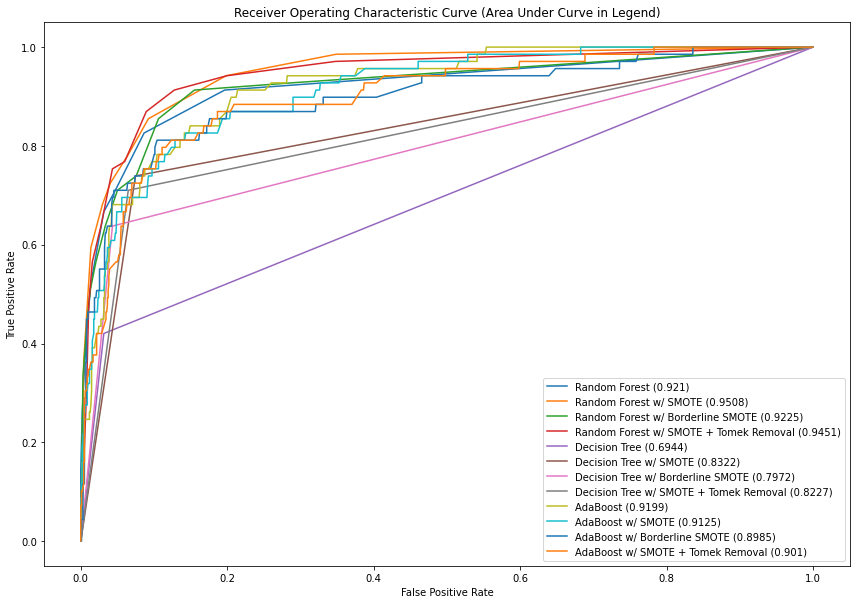

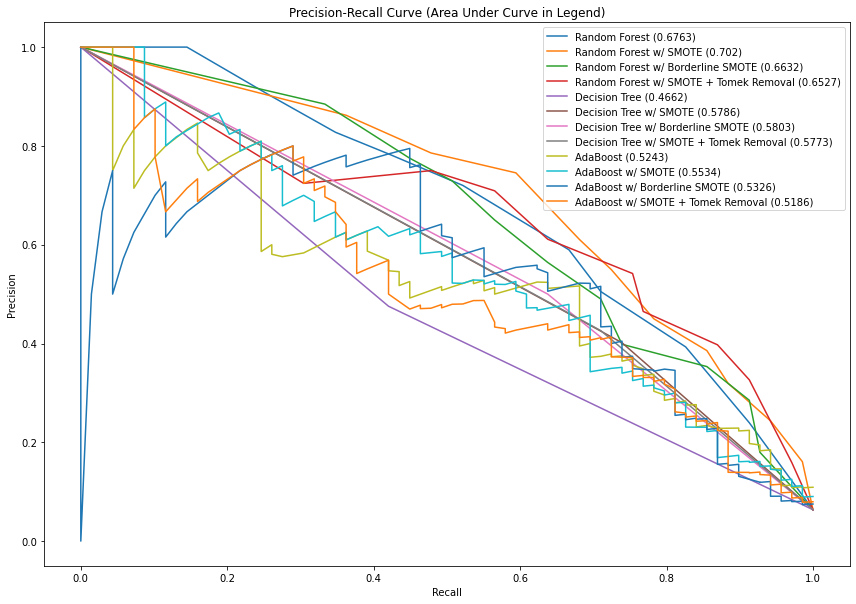

In [ ]:
fig, ax = plt.subplots(figsize=(12,8.5))

labels = []

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (Area Under Curve in Legend)')

for p in range(0, 12):
  labels.append(results['configuration'].iloc[p] + " (" + str(np.round(results['roc_auc'].iloc[p], 4)) + ")")
  plt.plot(results['fpr'].iloc[p], results['tpr'].iloc[p])

plt.legend(labels)
plt.tight_layout()

fig2, ax2 = plt.subplots(figsize=(12,8.5))

labels = []

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Area Under Curve in Legend)')

for p in range(0, 12):
  labels.append(results['configuration'].iloc[p] + " (" + str(np.round(results['prc_auc'].iloc[p], 4)) + ")")
  plt.plot(results['rec'].iloc[p], results['prec'].iloc[p])

plt.legend(labels)
plt.tight_layout()

Plotting cell for Cost-Sensitive Weight Balancing / ROC and Precision-Recall Curves

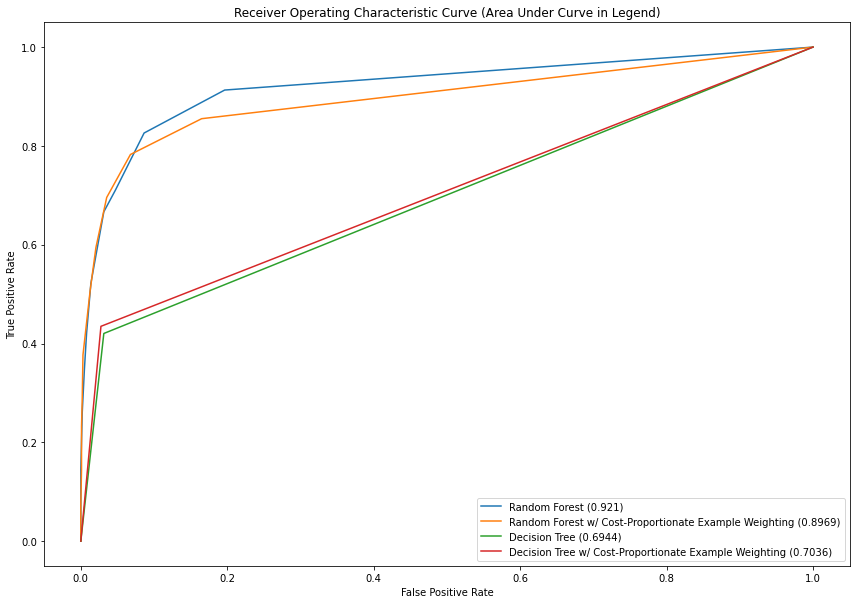

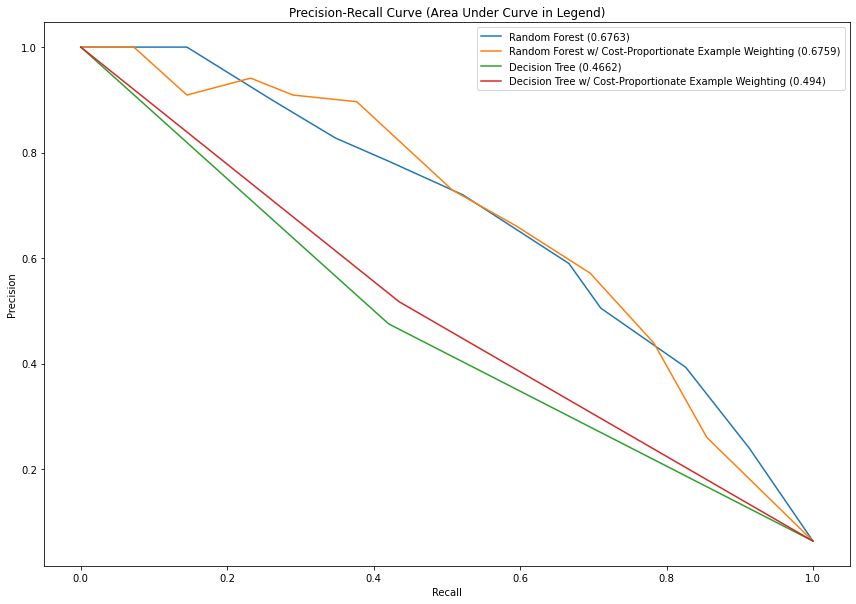

In [ ]:
fig3, ax3 = plt.subplots(figsize=(12,8.5))

labels = []

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (Area Under Curve in Legend)')

for p in [0,12,4,13]:
  labels.append(results['configuration'].iloc[p] + " (" + str(np.round(results['roc_auc'].iloc[p], 4)) + ")")
  plt.plot(results['fpr'].iloc[p], results['tpr'].iloc[p])

plt.legend(labels)
plt.tight_layout()

fig4, ax4 = plt.subplots(figsize=(12,8.5))

labels = []

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Area Under Curve in Legend)')

for p in [0,12,4,13]:
  labels.append(results['configuration'].iloc[p] + " (" + str(np.round(results['prc_auc'].iloc[p], 4)) + ")")
  plt.plot(results['rec'].iloc[p], results['prec'].iloc[p])

plt.legend(labels)
plt.tight_layout()

Plotting cell for Easy Ensemble / ROC and Precision-Recall Curves

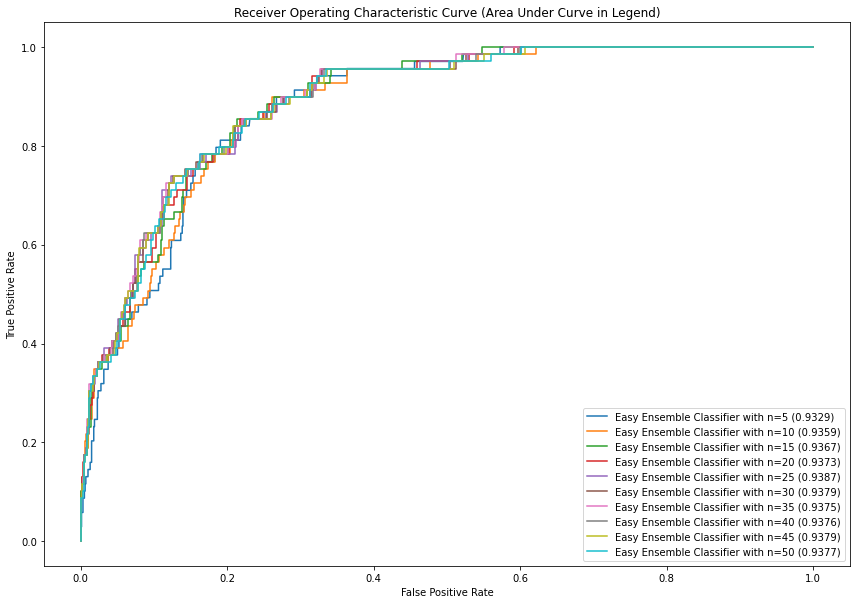

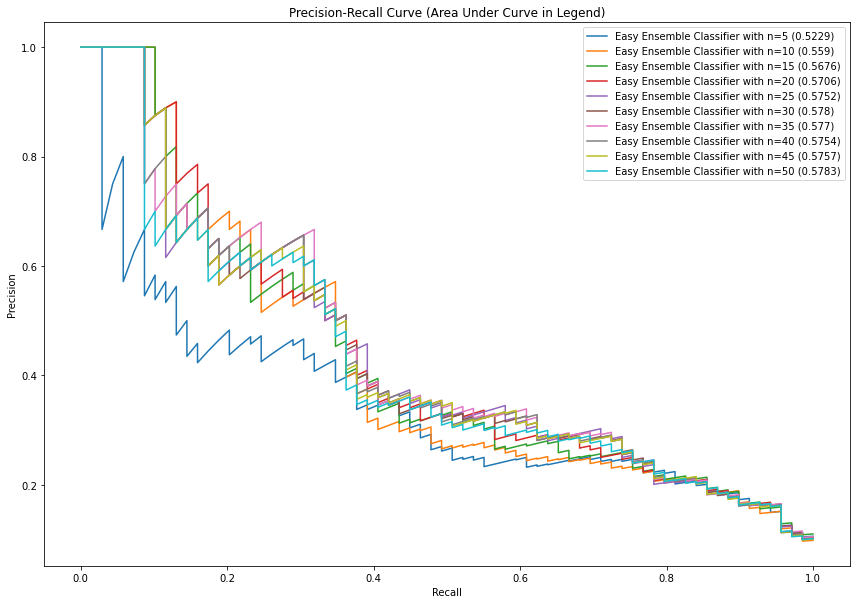

In [ ]:
fig5, ax5 = plt.subplots(figsize=(12,8.5))

labels = []

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (Area Under Curve in Legend)')

for p in range(14, 24):
  labels.append(results['configuration'].iloc[p] + " (" + str(np.round(results['roc_auc'].iloc[p], 4)) + ")")
  plt.plot(results['fpr'].iloc[p], results['tpr'].iloc[p])

plt.legend(labels)
plt.tight_layout()

fig6, ax6 = plt.subplots(figsize=(12,8.5))

labels = []

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Area Under Curve in Legend)')

for p in range(14, 24):
  labels.append(results['configuration'].iloc[p] + " (" + str(np.round(results['prc_auc'].iloc[p], 4)) + ")")
  plt.plot(results['rec'].iloc[p], results['prec'].iloc[p])

plt.legend(labels)
plt.tight_layout()

Plotting cell for SMOTE / Balanced Accuracy

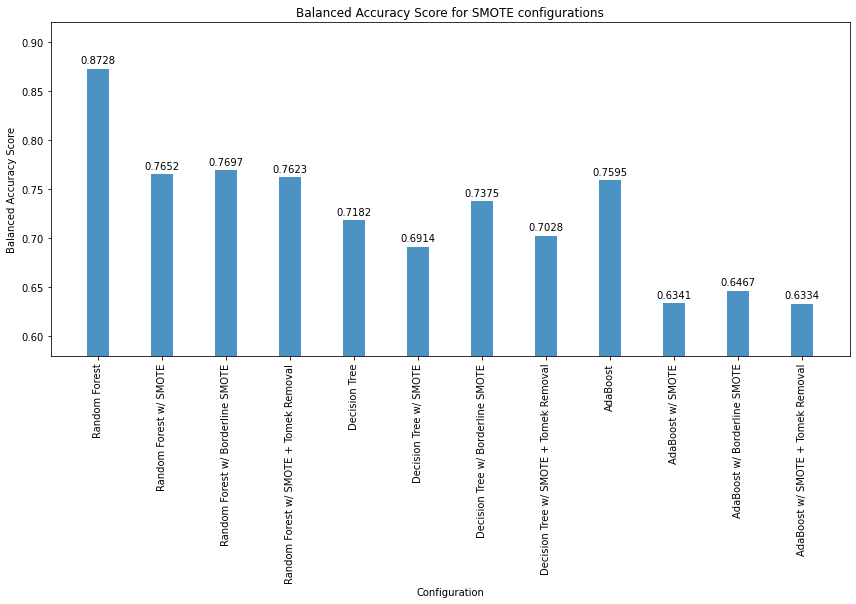

In [ ]:
fig, ax = plt.subplots(figsize=(12,8.5))
bar_width = 0.35
opacity = 0.8

rects = plt.bar(np.arange(12), results['acc_bal'].iloc[:12], bar_width, alpha=opacity)

plt.xlabel('Configuration')
plt.ylabel('Balanced Accuracy Score')
plt.title('Balanced Accuracy Score for SMOTE configurations')
plt.xticks(np.arange(12), results['configuration'].iloc[:12], rotation=90)

for p in rects:
  height = p.get_height()
  ax.annotate('{}'.format(round(height, 4)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.gca().set_ylim([0.58,0.92])

plt.tight_layout()
plt.show()

Plotting cell for Cost-Sensitive Weight Balancing / Balanced Accuracy

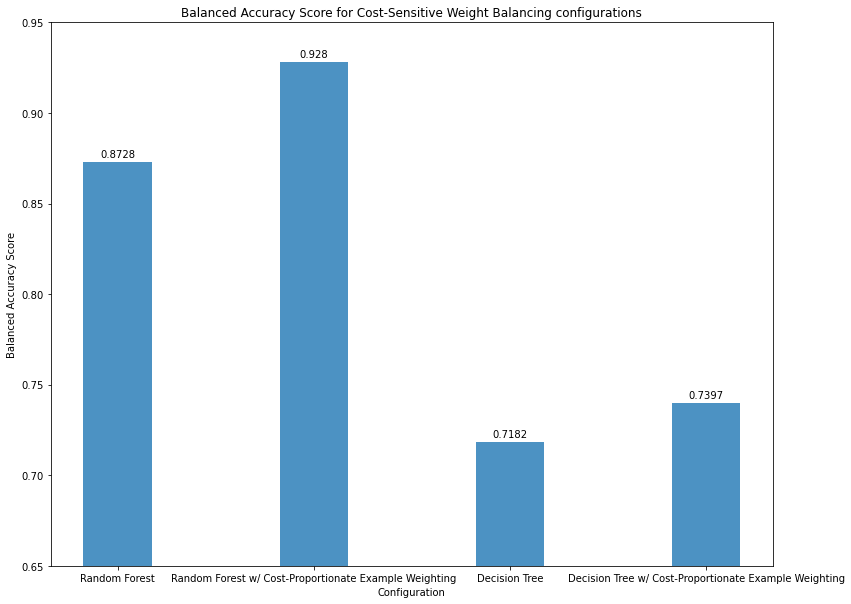

In [ ]:
fig, ax = plt.subplots(figsize=(12,8.5))
bar_width = 0.35
opacity = 0.8

rects = plt.bar(np.arange(4), results['acc_bal'].iloc[[0,12,4,13]], bar_width, alpha=opacity)

plt.xlabel('Configuration')
plt.ylabel('Balanced Accuracy Score')
plt.title('Balanced Accuracy Score for Cost-Sensitive Weight Balancing configurations')
plt.xticks(np.arange(4), results['configuration'].iloc[[0,12,4,13]], rotation=0)

for p in rects:
  height = p.get_height()
  ax.annotate('{}'.format(round(height, 4)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.gca().set_ylim([0.65,0.95])

plt.tight_layout()
plt.show()

Plotting cell for Easy Ensemble Configurations / Balanced Accuracy

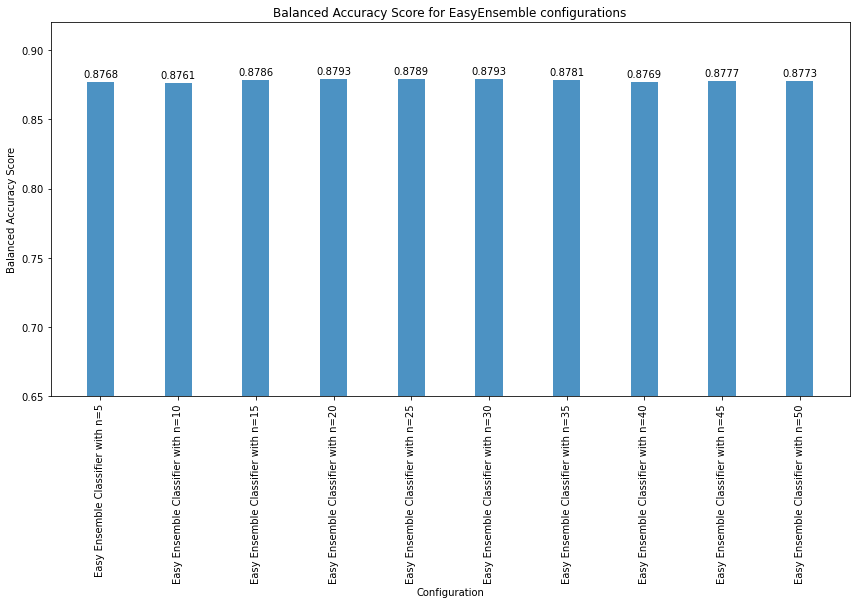

In [ ]:
fig, ax = plt.subplots(figsize=(12,8.5))
bar_width = 0.35
opacity = 0.8

rects = plt.bar(np.arange(10), results['acc_bal'].iloc[14:], bar_width, alpha=opacity)

plt.xlabel('Configuration')
plt.ylabel('Balanced Accuracy Score')
plt.title('Balanced Accuracy Score for EasyEnsemble configurations')
plt.xticks(np.arange(10), results['configuration'].iloc[14:], rotation=90)

for p in rects:
  height = p.get_height()
  ax.annotate('{}'.format(round(height, 4)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.gca().set_ylim([0.65,0.92])

plt.tight_layout()
plt.show()